## Importing libraries

In [30]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os


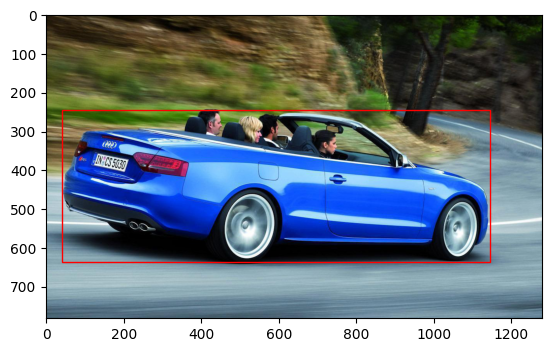

In [2]:
path_annotrain = "datasets_train/train_annotation/_annotation.csv"

train_annotation = pd.read_csv(path_annotrain, index_col=0)


bbox_train_full = train_annotation.loc[
    :, ["im_name", "x_min", "y_min", "x_max", "y_max","class"]
]

im_test = bbox_train_full.loc[0][0]
x1, y1, x2, y2,cl = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]


def load_plot(im_name, x1, y1, x2, y2):

    im = np.asanyarray(Image.open(f"datasets_train/train/{im_name}"))

    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
    )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()


load_plot(im_test, x1, y1, x2, y2)

In [3]:
bbox_train, bbox_eval = train_test_split(
    bbox_train_full, test_size=0.2, random_state=1234
)

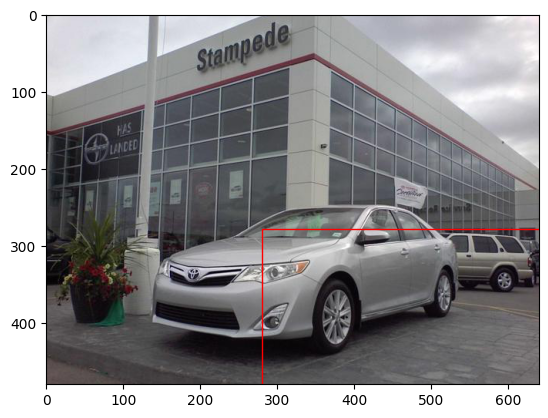

In [4]:
eval_pred = bbox_eval.copy()

# naive predictions for the bounded box
eval_pred["x_min"] = np.mean(bbox_train["x_min"])
eval_pred["x_max"] = np.mean(bbox_train["x_max"])
eval_pred["y_min"] = np.mean(bbox_train["y_min"])
eval_pred["y_max"] = np.mean(bbox_train["y_max"])

# test on the first image
im_pred_test = eval_pred.iloc[2, 0]
x1, y1, x2, y2,cl = eval_pred.loc[eval_pred["im_name"] == im_pred_test].iloc[0, 1:]

load_plot(im_pred_test, x1, y1, x2, y2)

In [5]:
cars_path = "car_models_footprint.csv"
car_models = pd.read_csv(cars_path, sep=";")

# randomly assign CO2 consumption of car models
np.random.seed(1234)

emission = car_models["Average of CO2 (g per km)"].dropna()
eval_pred["e"] = eval_pred["x_min"].apply(lambda x: np.random.choice(emission, 1)[0])

In [6]:
# # Submit the results
# eval_pred.to_csv(
#     "../../group_xxxxx_shared_workspace/submissions/test_team.csv", index=False
# )  # xxxx for your Hfactory ID group

### Car Detection

In [221]:
LABELS_FILE='yolo/coco.names'
CONFIG_FILE='yolo/yolov4.cfg'
WEIGHTS_FILE='yolo/yolov4.weights'
CONFIDENCE_THRESHOLD=0.3

net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)
LABELS = open(LABELS_FILE).read().strip().split("\n")
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]


In [241]:
def get_car_box(image):
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)

    (H, W) = image.shape[:2]

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection     
            scores = detection[5:]
            classID = np.argmax(scores)
            
            # Identification of the class, 
            # we are only interested in the case where the class is a car
            
            if(classID != 2):
                continue
            confidence = scores[classID]

            # filtering out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > CONFIDENCE_THRESHOLD:
                # scaling the bounding box coordinates back relative to the
                # size of the image
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                
                # Computing the top and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

            
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # applying non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
        CONFIDENCE_THRESHOLD)
    
    # Since we want to detect one car per image, we will only keep the car with the biggest area ( first plane)
    max_area = 0
    
    # ensuring at least that one detection exists
    if len(idxs) > 0:
        for i in idxs.flatten():
            (w, h) = (boxes[i][2], boxes[i][3])
            
            area = w*h
            # saving index of largest area
            if(area> max_area):
                max_area=area
                max_idx = i

        (x, y) = (boxes[max_idx][0], boxes[max_idx][1])
        (w, h) = (boxes[max_idx][2], boxes[max_idx][3])
#         cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 2)
#         text = "{}: {:.4f}".format(LABELS[classIDs[max_idx]], confidences[max_idx])
#         cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
#             0.5, (0,255,255), 2)
    else:
        # returning null vector if there is no car
        x,y,w,h = 0,0,0,0

    end = time.time()
#     print("[INFO] YOLO took {:.6f} seconds".format(end - start))
    
    return np.array([x,y, x+w,y+h])

In [212]:
# function to compute intersection over union
# ref: https://gist.github.com/meyerjo/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    if(np.all(boxA==0)):
        return 0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [239]:
data_test = pd.read_pickle("data_test.pkl")

In [234]:
data_test

,im_name
0,85854523.jpg
1,16663988681.jpg
2,19090334369.jpg
3,71540198.jpg
4,85427036.jpg
...,...
1018,89862599.jpg
1019,7055251597.jpg
1020,3848520911.jpg
1021,73537501.jpg


In [242]:
def get_predictions(df):
    result = pd.DataFrame(
        columns=['im_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])
    for i in range(df.shape[0]):
        im_test = df.iloc[i, 0]
        image = np.asanyarray(Image.open(f"datasets_train/test/{im_test}"))

        # Some images have 4 channels, other have 2 channels (2d)
        # To avoid confusing the yolo network, we will clip to 3 channels
        # and for the grayscale images, we will stack them together to make an RGB image that is in grayscale

        if(len(image.shape) == 0):
            print("shape not correct")
            scores.append(-1)
            continue
        if(len(image.shape) == 2):
            # converting grayscale to colored image
            image = np.stack((image,)*3, axis=-1)
        if(image.shape[2] > 3):
            image = image[:, :, :3]

        # predicting the bounding box with yolo and calculating the iou
        pred_box = get_car_box(image)

        if(np.all(pred_box == 0)):
            cl = 0
        else:
            cl = 1

        new_row = {'im_name': df.iloc[i, 0], 'x_min': pred_box[0], 'y_min': pred_box[1], 'x_max': pred_box[2], 'y_max': pred_box[3], 'class' : cl}
        result = result.append(new_row, ignore_index=True)

    return result

In [243]:
res = get_predictions(data_test)

In [268]:
res

,im_name,x_min,y_min,x_max,y_max,class
0,85854523.jpg,0,0,0,0,0
1,16663988681.jpg,0,0,0,0,0
2,19090334369.jpg,0,0,0,0,0
3,71540198.jpg,98,79,1620,815,1
4,85427036.jpg,234,195,1033,643,1
...,...,...,...,...,...,...
1018,89862599.jpg,23,109,970,571,1
1019,7055251597.jpg,0,0,0,0,0
1020,3848520911.jpg,0,0,0,0,0
1021,73537501.jpg,84,81,525,376,1


In [247]:
only_cars = res[res["class"]==1]

In [262]:
only_cars

,im_name,x_min,y_min,x_max,y_max,class
3,71540198.jpg,98,79,1620,815,1
4,85427036.jpg,234,195,1033,643,1
6,6087324064.jpg,1480,371,1602,705,1
8,11828073.jpg,19,62,614,417,1
11,5116251.jpg,96,77,1081,559,1
...,...,...,...,...,...,...
1015,38559539.jpg,116,90,841,447,1
1017,77082581.jpg,115,323,780,555,1
1018,89862599.jpg,23,109,970,571,1
1021,73537501.jpg,84,81,525,376,1


In [267]:
only_cars[['x_min','y_min','x_max','y_max']].values.sum()

822054

In [255]:
no_cars =  res[res["class"]==0]

In [248]:
only_cars.to_pickle("test_car_annotations.pkl") 

In [256]:
def display_box(df):
    for i in range(df.shape[0]):
        
        im_test = df.iloc[i, 0]
        image = np.asanyarray(Image.open(f"datasets_train/test/{im_test}"))
        
        cv2.rectangle(image, (df.iloc[i, 1], df.iloc[i, 2]), (df.iloc[i, 3], df.iloc[i, 4]), (255,0,0), 2)
        
        print(im_test)
        plt.imshow(image)
        plt.show()

In [259]:
display_box(only_cars)

## Methods used to track the iou and the performance of the model

In [213]:
# Returns the iuo scores of the dataframe given in input, where each row is an image
def get_iou_score(df):
    scores = []
    bad_iou_indices = []
    correct_car = 0 
    correct_no_car = 0
    false_car = 0
    false_no_car = 0
    for i in tqdm(range(df.shape[0])):
        im_test = df.iloc[i, 0]
        image = np.asanyarray(Image.open(f"datasets_train/train/{im_test}"))

       
        # Some images have 4 channels, other have 2 channels (2d)
        # To avoid confusing the yolo network, we will clip to 3 channels
        # and for the grayscale images, we will stack them together to make an RGB image that is in grayscale
        
        if(len(image.shape) == 0):
            print("shape not correct")
            scores.append(-1)
            continue
        if(len(image.shape)==2):
            # converting grayscale to colored image
            image = np.stack((image,)*3, axis=-1)    
        if(image.shape[2]>3):
            image = image[:,:,:3]
            
            
        # predicting the bounding box with yolo and calculating the iou
        pred_box = get_car_box(image)
        
    
        true_box = [df.iloc[i, 1],df.iloc[i, 2],df.iloc[i, 3],df.iloc[i, 4]]
        iou = bb_intersection_over_union(pred_box, true_box)
        
        true_class = df.iloc[i, 5]
        
        # Calculatin the TP,TN, FP, FN
        if(np.all(pred_box==0)):
            if(true_class != "car"):
                correct_no_car+=1
            else:
                false_no_car +=1
        else:
            if(true_class != "car"):
                false_car+=1
            else:
                correct_car +=1
            
        
        scores.append(iou)
        if(df.iloc[i, 5] != "car" and np.all(pred_box==0)):
            bad_iou_indices.append(i)

    return scores,correct_car, correct_no_car,false_car,false_no_car ,bad_iou_indices

In [269]:
scores_eval, TP, TN, FP, FN, bad_iou_indices = get_iou_score(bbox_train_full)

In [215]:
scores_eval = np.array(scores_eval)

scores_eval = scores_eval[~np.isnan(scores_eval)]
scores_eval = scores_eval[scores_eval > 0]
moyenne = np.mean(scores_eval[scores_eval != 0])

In [216]:
np.median(scores_eval[scores_eval != 0])

0.9214255444275123

In [217]:
moyenne

0.7727493824042925

In [271]:
plt.scatter(range(scores_eval.shape[0]),scores_eval,label='iou')
plt.hlines(moyenne,0,scores_eval.shape[0],'r',label='moyenne')
plt.legend()
plt.show()

In [272]:
# we will remove the ones corresponding to the not car images and the outliers
scores_eval_pur = scores_eval[scores_eval > 0.2]
plt.scatter(range(scores_eval_pur.shape[0]),scores_eval_pur,label='iou')
plt.hlines(moyenne,0,scores_eval_pur.shape[0],'r',label='moyenne')
plt.legend()
plt.show()

In [270]:
print("Nb of images in dataset: ",bbox_train_full.shape[0])
print("")
print("Nb of Truly detected cars: ",TP)
print(f"Proportion: {TP/bbox_train_full.shape[0]}")

print("")
print("Nb of Falsly detected cars(detect car, when there is no car): ",FP)
print(f"Proportion: {FP/bbox_train_full.shape[0]}")

print("")
print("Nb of Truly detected no cars: ",TN)
print(f"Proportion: {TN/bbox_train_full.shape[0]}")

print("")
print("Nb of undetected cars: ",FN)
print(f"Proportion: {FN/bbox_train_full.shape[0]}")
precision = TP/(TP + FP)
recall = TP/(TP + FN)

print("")
print(f"Precision: {precision}")

print("")
print(f"Recall: {recall}")

print("")
print(f"F-score: {(2*precision*recall)/(precision+recall)}")


### getting the images which have cars but not labeled as cars

In [200]:
print(bad_iou_indices)

[1347, 1813, 2240, 2537, 2617, 2636]


In [201]:
def get_ground_truth_from_indices(df,indices):
    for idx in indices:
        print("Index of below image: ",idx)
        im_test = df.iloc[idx, 0]
        image = np.asanyarray(Image.open(f"datasets_train/train/{im_test}"))
        x1,y1, x2,y2 = df.iloc[idx][1:5]
        pred_box = get_car_box(image)
        iou = bb_intersection_over_union(pred_box, [x1,y1, x2,y2])
        print("iou: ",iou)
        print("class: ",df.iloc[idx,5])
        load_plot(im_test,x1,y1, x2,y2)

In [260]:
# get_ground_truth_from_indices(bbox_train_full,bad_iou_indices)

## Creating the dataet that will be used in the fine tuning

In [155]:
data_tune = bbox_train_full.copy()
data_tune['class'] = np.where(data_tune['class'].isin(["car"]), 0, 1)
data_tune["im_path"] = "datasets_train\\train\\" + data_tune['im_name'].astype(str)

temp_cols=data_tune.columns.tolist()
new_cols=['im_path','im_name','class','x_min','y_min','x_max','y_max']
data_tune=data_tune[new_cols]
data_tune = data_tune.dropna()

data_tune['cx'] = (data_tune['x_min'] + data_tune['x_max']) /2
data_tune['cy'] = (data_tune['y_min'] + data_tune['y_max']) /2
data_tune['width'] = data_tune['x_max'] - data_tune['x_min']
data_tune['height'] = data_tune['y_max'] - data_tune['y_min']

data_tune = data_tune.drop(["x_min","x_max","y_min","y_max"],axis=1)

In [93]:
data_tune.head(10)

,im_path,im_name,class,cx,cy,width,height
0,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,107347968.jpg,0,592.000000,440.500000,1104.000000,393.000000
1,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,91160576.jpg,0,51.000000,42.500000,94.000000,67.000000
2,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,273809408.jpg,0,152.000000,97.500000,272.000000,187.000000
3,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,579534848.jpg,0,134.500000,100.500000,241.000000,155.000000
4,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,950599680.jpg,0,162.500000,142.500000,317.000000,145.000000
...,...,...,...,...,...,...,...
9690,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,9403488242.jpg,1,1001.922000,785.934134,1739.368000,828.912720
14225,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,2224571280.jpg,1,464.737443,319.890335,443.999124,376.977450
15669,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,146443543.jpg,1,1280.757400,800.997426,1646.022320,1462.734268
16445,C:\Users\walid\Desktop\hi__paris_2022_hackatho...,15666905933.jpg,1,1451.933280,940.973664,172.065024,129.995328


### Exporting the dataset into the yolov4 format: jpg file and txt file for annotations in order to carry on with the fine tuning

In [261]:
for i in range(data_tune.shape[0]):
    name = os.path.splitext(data_tune.iloc[i]['im_name'])[0]
    filename = name +'.txt'
    image =  np.asanyarray(Image.open(data_tune.iloc[i][0]))
    
    try:
        (H, W) = image.shape[:2]
    except:
        print(filename)
        continue
    if(data_tune.iloc[i][2] != 0):
        continue
    im = Image.fromarray(image)
    im.save("train_labels/" + name + ".jpg")
    box = data_tune.iloc[i][3:7] / np.array([W, H, W, H])
    complete_data = pd.concat([pd.Series(data_tune.iloc[i][2]), box])
    np.savetxt(f"train_labels/{filename}", pd.DataFrame([complete_data]), fmt='%d %f %f %f %F')
